## Datasets

In [ ]:
## Datasets
## 1. Twitter sentiment extraction Kaggle dataset (27k): https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview
## 2. Imdb dataset (25k training and 25k testing): http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
## 3. Sentiment140 (1.4M): http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
## 4. Sandars: https://github.com/zfz/twitter_corpus/blob/09afbfb5b580c848062aadbc4491fecc96b0a85a/full-corpus.csv

## Importing libraries and tools

In [ ]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [ ]:
# import locale
# print(locale.getpreferredencoding())

In [ ]:
!python --version

Python 3.9.16


In [2]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=e6e817dc25f0e5b9a07b121317abc9ea532f4a1236675c4c9308f417717a2eb3
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import csv
import os
import sys
import pickle
import subprocess

from sklearn.utils import shuffle

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# import spacy
import emoji

In [4]:
## Versions
print('Python version:', sys.version)
print('NumPy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('TensorFlow version:', tf.__version__)

Python version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
NumPy version: 1.22.4
Pandas version: 1.5.3
TensorFlow version: 2.12.0


In [5]:
from google.colab import files
file = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


## Utility functions

In [6]:
# import pandas as pd
# import numpy as np
# import csv

# from sklearn.utils import shuffle

# filepath = 'train.csv'
def pre_processing(filepath, split_size=None, num_classes=2, training_data=True, random_state=0, selected_text=False):
    """
    Returns the training and validation data lists from the input csv path if training_data is True.
    Else it returns testing data from the filepath. 

    This function is specific to the Twitter Sentiment extraction Kaggle dataset.
    Link to data: https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview

    Parameters:
        filepath (string): path to the data
        split_size (float): train and test data ratio
        num_classes (int): number of classes in the output labels
        random_state (int): random_state for sklearn.shuffle
        selected_text (bool): choosing selected text or total text from the train data

    Returns:
        if split_size is not None:
        train_sentences (list): A list of strings for training
        train_labels (list): A list of integers representing different classes for training
        validation_sentences (list): A list of strings for validation
        validation_labels (list): A list of integers representing different classes for validation

        if split_size is None:
        sentences (list): A list of strings
        labels (list): A list of integers representing different classes
    """

    assert num_classes == 3 or num_classes == 2, "num_classes takes only integer values of 2 or 3"

    if training_data == True:
        label_col, text_col = 3, 1
    else:
        label_col, text_col = 2, 1

    sentences = []
    labels = [] 
    with open(filepath) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row[text_col]) <= 0: # Min number of characters
                continue
            # Appending classes: positive:1, negative:0, neutral:2
            if num_classes == 3:
                labels.append(0 if row[label_col]=='negative' else 1 if row[label_col]=='positive' else 2)
            elif num_classes == 2:
                if row[label_col] == 'neutral': continue
                labels.append(0 if row[label_col]=='negative' else 1)
            else:
                raise ValueError("num_classes takes only integer values of 2 or 3")

            sentences.append(row[text_col])

    # shuffling the data
    sentences, labels = shuffle(sentences, labels, random_state=random_state)

    if split_size is not None:
        train_size = int(len(sentences) * split_size)

        # splitting the data
        train_sentences = sentences[:train_size]
        train_labels = labels[:train_size]

        validation_sentences = sentences[train_size:]
        validation_labels = labels[train_size:]

        assert len(np.unique(train_labels)) == len(np.unique(validation_labels)), "Training or Validation sets have missing labels. Try a different random_state."
        
        return train_sentences, train_labels, validation_sentences, validation_labels
    
    else:
        return sentences, labels

# Plot Utility
def plot_graphs(history, string):
    """Plots the train or validation losses and accuracies for each epoch."""
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


## Saving entire model
def save_model_tokenizer(model, tokenizer, name_tag='my', folder='saved_model'):
    subprocess.run("mkdir -p saved_model".split())
    
    # Saving tokenizer
    with open('{}/{}_tokenizer.pickle'.format(folder, name_tag), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Saving model
    model.save(os.path.join(folder, '{}_model'.format(name_tag)))

def text_preprocessing(sentences):
    # 1. Hastags to words, Emojis to text, replace '_', ':' and '.' with space ' '
    cleaned_sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(re.sub(r'#(\w+)\b', r'\1', sentence))) for sentence in sentences]
    # # 2. Removing stop words
    # en = spacy.load('en_core_web_sm')
    # sw_spacy = en.Defaults.stop_words
    # cleaned_sentences = [' '.join([word for word in sentence.split() if word not in sw_spacy]) for sentence in cleaned_sentences]
    return cleaned_sentences

def transform_tweets(tweets, tokenizer, max_length=35):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences,maxlen=max_length)
    return padded

## Understanding data

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [ ]:
print('Data points per class:'.upper())
for group, df_group in df.groupby('sentiment'):
    print(group, len(df_group))

DATA POINTS PER CLASS:
negative 7781
neutral 11118
positive 8582


In [ ]:
## Tentative preprocessing steps:
## 1. Remove tweets with zero length or below below some threshold.
## 

In [ ]:
print('Statistics on length of text and selected_text:')
text_lengths = [len(string) for string in sentences]
selected_text_lengths = [len(string) for string in selected_sentences]
print('Min length:', np.min(text_lengths), np.min(selected_text_lengths))
print('Max length:', np.max(text_lengths), np.max(selected_text_lengths))
print('Average length: {:.2f} {:.2f}'.format(np.mean(text_lengths), np.mean(selected_text_lengths)))

Statistics on length of text and selected_text:
Min length: 0 0
Max length: 141 141
Average length: 68.33 36.71


## Modeling: Twitter data

### Preparing Data

In [ ]:
# import tensorflow as tf 
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [7]:
# Global Parameters
vocab_size = 10000
max_length = 35
oov_token = '<OOV>'
trunc_type = 'post'
padding_type = 'post'

In [8]:
filepath = 'train.csv'
train_sentences, train_labels, validation_sentences, validation_labels = pre_processing(filepath, split_size=0.9, training_data=True)
filepath = 'test.csv'
test_sentences, test_labels = pre_processing(filepath, training_data=False)

print('Training examples:', len(train_sentences))
print('\tPositive examples:', sum([1 for label in train_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in train_labels if label == 0 ]))
print('Validation examples:', len(validation_sentences))
print('\tPositive examples:', sum([1 for label in validation_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in validation_labels if label == 0 ]))
print('Test examples:', len(test_sentences))
print('\tPositive examples:', sum([1 for label in test_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in test_labels if label == 0 ]))

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
index_word = tokenizer.index_word
print('Corpus size:', len(word_index))

# Tokenizing training data
num_classes = 2
train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# train_labels = tf.keras.utils.to_categorical(np.array(train_labels), num_classes=num_classes, dtype='float32')

# Tokenizing validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
padded_validation_sequences = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# validation_labels = tf.keras.utils.to_categorical(np.array(validation_labels), num_classes=num_classes, dtype='float32')

# Tokenizing test data
test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(test_sequences,  maxlen=max_length, padding=padding_type, truncating=trunc_type)
# test_labels = tf.keras.utils.to_categorical(np.array(test_labels), num_classes=num_classes, dtype='float32')


Training examples: 14726
	Positive examples: 7737
	Negative examples: 6989
Validation examples: 1637
	Positive examples: 845
	Negative examples: 792
Test examples: 2104
	Positive examples: 1103
	Negative examples: 1001
Corpus size: 17750


In [9]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)
test_labels = np.array(test_labels)

### Cross-Validation

In [ ]:
## Hyperparameters
# dropout_rates = [0.4, 0.5, 0.6]
# embedding_dims = [16, 32]
# lstm_dims = [16, 24, 32, 64]
# dense_dims = [16, 24, 32]


In [ ]:
## Hyperparameters
dropout_rates = [0.4, 0.6]
embedding_dims = [16, 32]
lstm_dims = [16, 24, 32]
dense_dims = [16, 32]

In [ ]:

def run_model(embedding_dim, lstm_dim, dense_dim, dropout_rate, epochs = 10):
    
    # Model Definition with LSTM
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Set the training parameters
    model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    # Train the model
    history_lstm = model_lstm.fit(padded_train_sequences, train_labels, epochs=epochs, validation_data=(padded_validation_sequences, validation_labels), verbose=2)

    model_params.append([embedding_dim, lstm_dim, dense_dim, dropout_rate, epochs])
    history.append(history_lstm.history)



In [ ]:
count = 0
epochs = 15
model_params = []
history = []
for embedding_dim in embedding_dims:
    for lstm_dim in lstm_dims:
        for dense_dim in dense_dims:
            for dropout_rate in dropout_rates:
                print('Model Number:', count := count + 1)
                print('Model Params:', embedding_dim, lstm_dim, dense_dim, dropout_rate, epochs)
                run_model(embedding_dim, lstm_dim, dense_dim, dropout_rate, epochs = epochs)
 

In [ ]:
import json
with open('history.json', 'w') as f:
    json.dump(history, f)

with open('model_params.json', 'w') as f:
    json.dump(model_params, f)

In [ ]:
history[0]

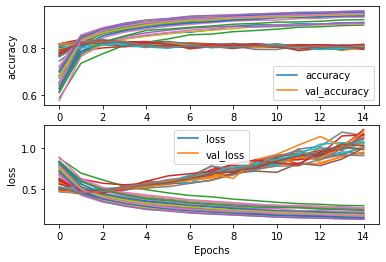

In [ ]:
import matplotlib.pyplot as plt

# Plot Utility
# plt.subplots(1, 2)
def plot_graphs(history, string):
  if string == 'accuracy':
    plt.subplot(2, 1, 1)
  else: plt.subplot(2, 1, 2) 
  plt.plot(history[string])
  plt.plot(history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
#   plt.show()

# Plot the accuracy and loss history
for h in history:
    plot_graphs(h, 'accuracy')
    plot_graphs(h, 'loss')

### Model 1: LSTM Model (without GloVe embeddings)

In [ ]:
def model_one():
    # Parameters
    # vocab_size = 10000
    embedding_dim = 16
    lstm_dim = 32
    dense_dim = 24

    # Model Definition with LSTM
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Set the training parameters
    model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    # Print the model summary
    model_lstm.summary()

    NUM_EPOCHS = 10

    # Train the model
    print('\nTRAINING MODEL:')
    history_lstm = model_lstm.fit(padded_train_sequences, train_labels, epochs=NUM_EPOCHS, validation_data=(padded_validation_sequences, validation_labels))

    # Evaluating on test data
    print('\nEVALUATING MODEL ON TEST DATA:')
    model_lstm.evaluate(padded_test_sequences, test_labels)

    return history_lstm

history = model_one()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 35, 16)            160000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                                 
 dropout_13 (Dropout)        (None, 24)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 75        
                                                      

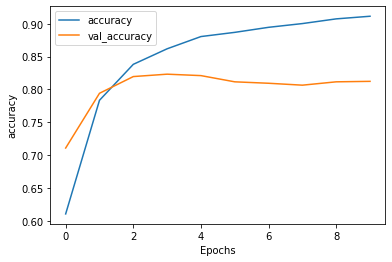

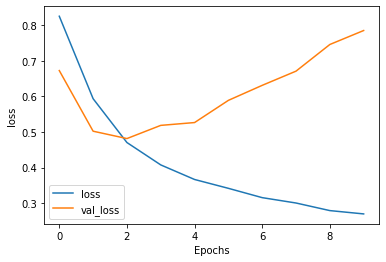

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Model 2: LSTM-CNN Model (without GloVe embeddings)

In [ ]:
### LSTM-CNN MODEL
def model_two():
    # Parameters
    # vocab_size = 10000
    embedding_dim = 16
    lstm_dim = 32
    dense_dim = 24

    # Model Definition with LSTM
    model_lstm_conv = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Set the training parameters
    model_lstm_conv.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    # Print the model summary
    model_lstm_conv.summary()

    NUM_EPOCHS = 10

    # Train the model
    print('\nTRAINING MODEL:')
    history_lstm_conv = model_lstm_conv.fit(padded_train_sequences, train_labels, epochs=NUM_EPOCHS, validation_data=(padded_validation_sequences, validation_labels))

    # Evaluating on test data
    print('\nEVALUATING MODEL ON TEST DATA:')
    model_lstm_conv.evaluate(padded_test_sequences, test_labels)

    return history_lstm_conv 

history = model_two()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 35, 16)            160000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 35, 64)           12544     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 35, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 31, 128)           41088     
                                                                 
 global_average_pooling1d_5   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 24)               

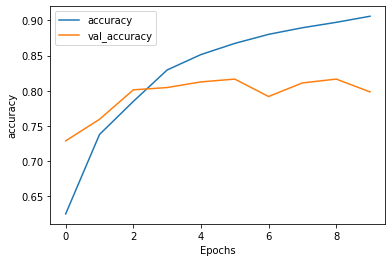

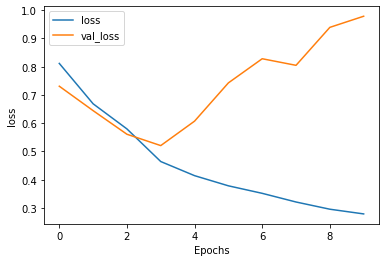

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Downloading Twitter GloVe Embeddings

In [10]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2023-04-29 06:58:13--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2023-04-29 06:58:13--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.01MB/s    in 4m 44s  

2023-04-29 07:02:57 (5.10 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [11]:
!unzip -q glove.twitter.27B.zip

In [ ]:
!du .

72	./.config/logs/2023.03.23
76	./.config/logs
8	./.config/configurations
108	./.config
55508	./sample_data
5301812	.


In [12]:
glove_embeddings = ['glove.twitter.27B.25d.txt',
                    'glove.twitter.27B.50d.txt',
                    'glove.twitter.27B.100d.txt',
                    'glove.twitter.27B.200d.txt',
                    ]
                    
filepath = glove_embeddings[1]

embeddings_index = {}
with open(filepath) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [ ]:
len(embeddings_index)

1193514

### Creating the Embedding matrix

In [13]:
# vocab_size = 10000
embedding_dim = 50
num_tokens = vocab_size + 1

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for index in range(2, num_tokens):
    word = index_word[index]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Model 3: LSTM Model (GloVe)

In [ ]:
def model_three():
    # Parameters
    lstm_dim = 32
    dense_dim = 24
    dropout_rate = 0.6

    # Model Definition with LSTM
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_tokens, embedding_dim, input_length=max_length, 
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Set the training parameters
    model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    # Print the model summary
    model_lstm.summary()

    NUM_EPOCHS = 15

    # Train the model
    print('\nTRAINING MODEL:')
    history_lstm = model_lstm.fit(padded_train_sequences, train_labels, epochs=NUM_EPOCHS, validation_data=(padded_validation_sequences, validation_labels))

    # Evaluating on test data
    print('\nEVALUATING MODEL ON TEST DATA:')
    model_lstm.evaluate(padded_test_sequences, test_labels)

    return history_lstm 

history = model_three()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 35, 50)            500050    
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               21248     
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 24)                1560      
                                                                 
 dropout_21 (Dropout)        (None, 24)                0         
                                                                 
 dense_19 (Dense)            (None, 3)                 75        
                                                      

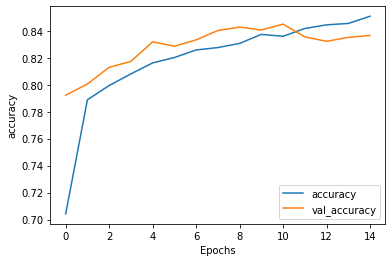

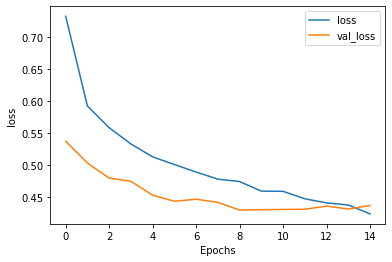

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Model 4: LSTM-CNN Model (GloVe)

In [ ]:
def model_four():
    # Parameters
    lstm_dim = 32
    dense_dim = 24
    conv_filters = 64
    dropout_rate = 0.6

    # Model Definition with LSTM
    model_lstm_conv = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_tokens, embedding_dim, input_length=max_length, 
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv1D(conv_filters, 5),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(3, activation='softmax'),
    ])

    # Set the training parameters
    model_lstm_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    model_lstm_conv.summary()

    NUM_EPOCHS = 15

    # Train the model
    print('\nTRAINING MODEL:')
    history_lstm_conv = model_lstm_conv.fit(padded_train_sequences, train_labels, epochs=NUM_EPOCHS, validation_data=(padded_validation_sequences, validation_labels))


    # Evaluating on test data
    print('\nEVALUATING MODEL ON TEST DATA:')
    model_lstm_conv.evaluate(padded_test_sequences, test_labels)

    return history_lstm_conv, model_lstm_conv

history, model = model_four()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 50)            500050    
                                                                 
 bidirectional (Bidirectiona  (None, 35, 64)           21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 35, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 31, 64)            20544     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 re_lu (ReLU)                (None, 64)                0

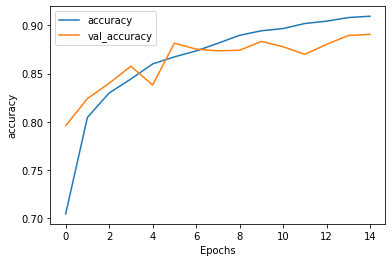

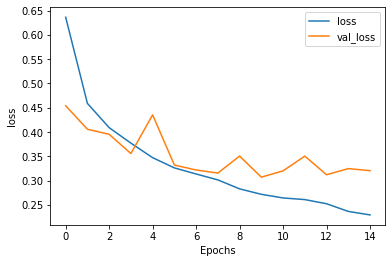

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# Utitility functions
## Saving entire model
import pickle
import os
import subprocess

def save_model_tokenizer(model, tokenizer, name_tag='my', folder='saved_model'):

    # Saving tokenizer
    with open('{}_tokenizer.pickle'.format(name_tag), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Saving model
    subprocess.run("mkdir -p saved_model".split())
    model.save(os.path.join(folder, '{}_model'.format(name_tag)))

In [ ]:
save_model_tokenizer(model, tokenizer, name_tag='sentiment')

In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

updating: content/saved_model/ (stored 0%)
  adding: content/saved_model/sentiment_model/ (stored 0%)
  adding: content/saved_model/sentiment_model/variables/ (stored 0%)
  adding: content/saved_model/sentiment_model/variables/variables.index (deflated 64%)
  adding: content/saved_model/sentiment_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: content/saved_model/sentiment_model/saved_model.pb (deflated 90%)
  adding: content/saved_model/sentiment_model/assets/ (stored 0%)
  adding: content/saved_model/sentiment_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/sentiment_model/keras_metadata.pb (deflated 61%)


In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

from google.colab import files
files.download("/content/saved_model.zip")
files.download('/content/sentiment_tokenizer.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the saved model
new_model = tf.keras.models.load_model('saved_model/my_sentiment_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 50)            500050    
                                                                 
 bidirectional (Bidirectiona  (None, 35, 64)           21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 35, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 31, 64)            20544     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 re_lu (ReLU)                (None, 64)                0

### Model 4.1: LSTM-CNN Model (GloVe, two classes)

In [14]:
def model_four():
    # Parameters
    lstm_dim = 32
    dense_dim = 24
    conv_filters = 64
    dropout_rate = 0.6

    # Model Definition with LSTM
    model_lstm_conv = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_tokens, embedding_dim, input_length=max_length, 
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv1D(conv_filters, 5),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    # Set the training parameters
    model_lstm_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    model_lstm_conv.summary()

    NUM_EPOCHS = 15

    # Train the model
    print('\nTRAINING MODEL:')
    history_lstm_conv = model_lstm_conv.fit(padded_train_sequences, train_labels, epochs=NUM_EPOCHS, validation_data=(padded_validation_sequences, validation_labels))


    # Evaluating on test data
    print('\nEVALUATING MODEL ON TEST DATA:')
    model_lstm_conv.evaluate(padded_test_sequences, test_labels)

    return history_lstm_conv, model_lstm_conv

history, model = model_four()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 50)            500050    
                                                                 
 bidirectional (Bidirectiona  (None, 35, 64)           21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 35, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 31, 64)            20544     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 re_lu (ReLU)                (None, 64)                0

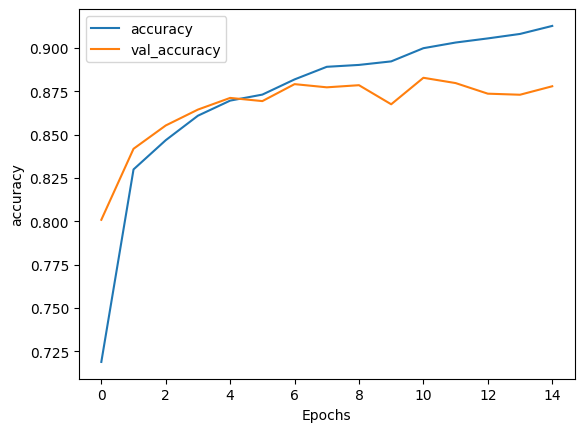

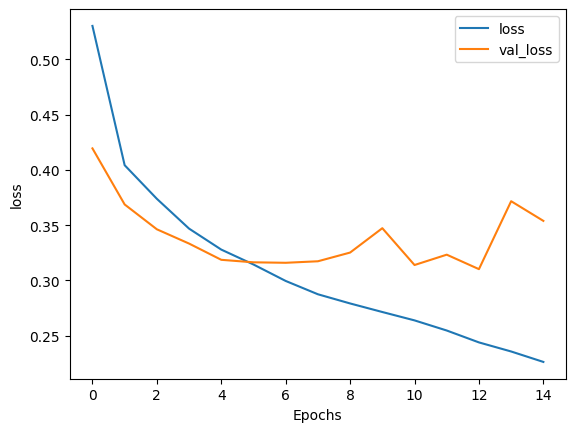

In [15]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

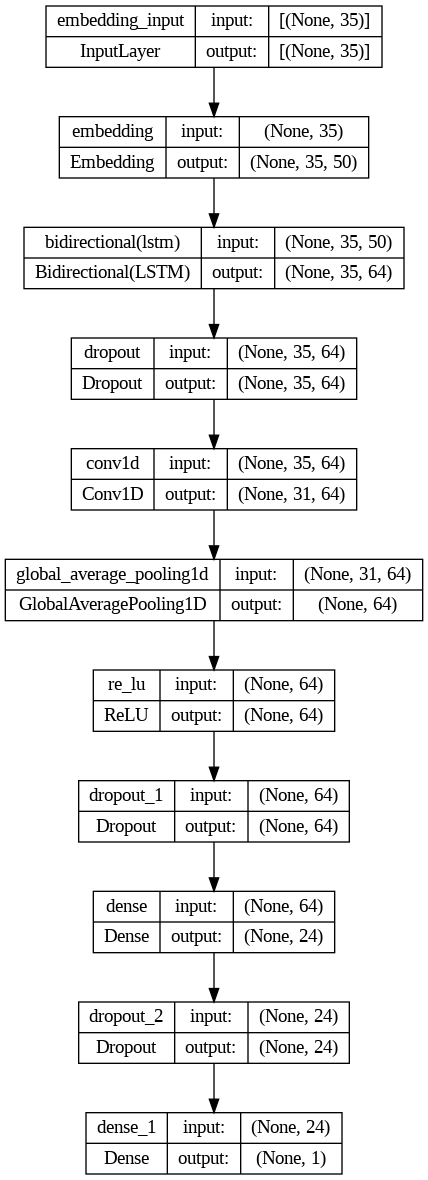

In [16]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='sentiment_model.png')

In [17]:
save_model_tokenizer(model, tokenizer, name_tag='sentiment')

## Modeling: IMDB dataset

### Preparing Data

In [ ]:
# 2
# !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf /content/aclImdb_v1.tar.gz

In [ ]:
## Common labels used:
## Postive = 0, Neutral = 1, Negative = 2

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [ ]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
!pip install spacy
!pip install emoji

In [ ]:
import spacy
import emoji

def text_preprocessing(sentences):
    cleaned_sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(sentence)) for sentence in sentences]
    en = spacy.load('en_core_web_sm')
    sw_spacy = en.Defaults.stop_words
    cleaned_sentences = [' '.join([word for word in sentence.split() if word not in sw_spacy]) for sentence in cleaned_sentences]
    return cleaned_sentences

In [ ]:
training_sentences = text_preprocessing(training_sentences)
testing_sentences = text_preprocessing(testing_sentences)

In [ ]:
training_labels_final[:3]

array([0, 0, 0])

In [ ]:
training_sentences[:3]

["This absolutely terrible movie Don't lured Christopher Walken Michael Ironside Both great actors, simply worst role history Even great acting redeem movie's ridiculous storyline This movie early nineties US propaganda piece The pathetic scenes Columbian rebels making cases revolutions Maria Conchita Alonso appeared phony, pseudo-love affair Walken pathetic emotional plug movie devoid real meaning I disappointed movies like this, ruining actor's like Christopher Walken's good I barely sit",
 'I known fall asleep films, usually combination things including, tired, warm comfortable sette having eaten lot However occasion I fell asleep film rubbish The plot development constant Constantly slow boring Things happen, explanation causing I admit, I missed film, watched majority happen accord real concern I cant recommend film',
 'Mann photographs Alberta Rocky Mountains superb fashion, Jimmy Stewart Walter Brennan enjoyable performances <br /><br />But come Hollywood - Mountie telling peopl

In [ ]:
max([len(sentence.split(' ')) for sentence in training_sentences])

1421

In [ ]:
# Global Parameters
vocab_size = 10000
max_length = 120
oov_token = '<OOV>'
trunc_type = 'post'
padding_type = 'post'

In [ ]:
# Parameters
# vocab_size = 10000
# max_length = 120
# trunc_type='post'
# oov_token = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


### Model 5: LSTM Model (without GloVe embeddings)

In [ ]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 120, 16)           160000    
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               12544     
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 6)                 390       
                                                                 
 dense_23 (Dense)            (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 31s 131ms/step - loss: 0.5495 - accuracy: 0.6990 - val_loss

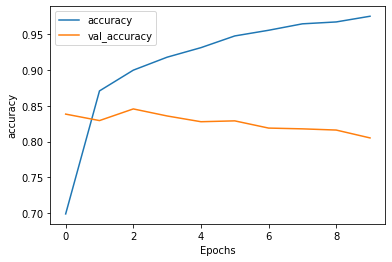

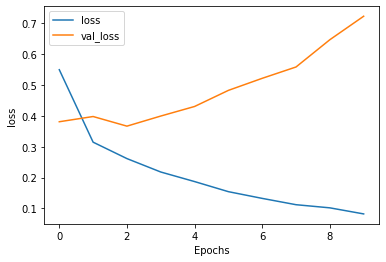

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

### Creating the Embedding matrix

In [ ]:
# vocab_size = 10000
embedding_dim = 50
num_tokens = vocab_size + 1

hits, misses = 0, 0
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for index in range(2, num_tokens):
    word = index_word[index]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        hits += 1
    else:
        misses += 1
print('Hits: {}\nMisses: {}'.format(hits, misses))

Hits: 9598
Misses: 401


### Model 6: LSTM-CNN Model (GloVe)

In [ ]:
# model_six is a binary version of model_four which has 3 classes
def model_six(): 
    # Parameters
    lstm_dim = 32
    dense_dim = 24
    conv_filters = 64
    dropout_rate = 0.6

    # Model Definition with LSTM
    model_lstm_conv = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_tokens, embedding_dim, input_length=max_length, 
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv1D(conv_filters, 5),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Set the training parameters
    model_lstm_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    # Print the model summary
    model_lstm_conv.summary()

    NUM_EPOCHS = 15
    BATCH_SIZE = 128

    # Train the model
    print('\nTRAINING MODEL:')
    history_lstm_conv = model_lstm_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

    return history_lstm_conv, model_lstm_conv

history, model = model_six()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 50)           500050    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 120, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 116, 64)           20544     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 re_lu (ReLU)                (None, 64)                0

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Prediction on latest Tweets

### Scraping tweets

In [ ]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print('Getting Twitter Data...')

import snscrape.modules.twitter as sntwitter

query = 'Covid lang:en'

tweet_list = []
meta_data = []
counter = 0
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    # print(vars(tweet))
    # print(type(tweet))
    meta_data.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username, tweet.url])
    tweet_list.append(tweet.rawContent)
    counter += 1
    if counter >= 100:
        break
    

print(tweet_list)
print(len(tweet_list))

Getting Twitter Data...
['@POTUS The only reason the economy was reeling is because you and the democrats released Covid 19 so that you could rig the election. The democrats are at fault for everything that has happened to the US.', '@WakeAwake1 Without a doubt, the cops already have, remember the covid police', '@POTUS Liar! The Democrats created and unleashed Covid for the specific reason of destroying DJT, and tanking the economy. All you did was turn the faucet on after all the State Democrat Governors turned it off! You know you’re a failure, and so do we!', '@DavidCass_ @lukefairbairn7 Who says fc are skint? They have signed one of the biggest shirt deals for next season once the Hummel garbage is over, the books are balanced baring the covid loan \U0001fae0', 'COVID-19 Remains #1 Cause of Line-of-Duty Fatalities For U.S. Law Enforcement\nSource:\n(1) Latest Fatality Reports - National Law Enforcement Officers Memorial Fund (https://t.co/dzEb3czWOK)\n(2) 2021 Fatalities Report (h

In [ ]:
i = 0
print(tweet_list[i])
print(meta_data[i][-1])

#doctors  are inspiring figures in society; their efforts should be celebrated every day. Wishing you a happy National Doctors' Day! A salute to all doctors for their heroic job, especially when the COVID-19 pandemic hit the world.👩🏻‍⚕️🧑🏻‍⚕️ 

#nation…https://t.co/WTys3K2udi
https://twitter.com/MohammedShanus/status/1641474833623175168


In [ ]:
## Steps:
# 1. Convert all hashtags to words
# 2. Convert all emojis to words (probably in camel case)
# 3. substitute ':' with ' : '
# 4. substitute '_' with ' '
# NOTE: Steps 3 and 4 is done by Tokenizer

In [ ]:
tweet = tweet_list[i]

### Preprocessing tweets

In [ ]:
# !pip install spacy

In [ ]:
# import spacy
import emoji
import re

def text_preprocessing(sentences):
    # 1. Hastags to words, Emojis to text, replace '_', ':' and '.' with space ' '
    cleaned_sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(re.sub(r'#(\w+)\b', r'\1', sentence))) for sentence in sentences]
    # # 2. Removing stop words
    # en = spacy.load('en_core_web_sm')
    # sw_spacy = en.Defaults.stop_words
    # cleaned_sentences = [' '.join([word for word in sentence.split() if word not in sw_spacy]) for sentence in cleaned_sentences]
    return cleaned_sentences

def transform_tweets(tweets, tokenizer, max_length=35):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences,maxlen=max_length)
    return padded


In [ ]:
# pre-processing
tweet_list = text_preprocessing(tweet_list)
print(tweet_list)

# # loading tokenizer
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# test_input = transform_tweets(tweet_list, tokenizer, max_length=35)

# # Checking tokenization
# print([index_word[index] for index in test_input[0] if index != 0])

["doctors  are inspiring figures in society; their efforts should be celebrated every day  Wishing you a happy National Doctors' Day! A salute to all doctors for their heroic job, especially when the COVID-19 pandemic hit the world  woman health worker light skin tone  health worker light skin tone  \n\nnation…https //t co/WTys3K2udi", '"I want to return to the position and fully implement the remaining part of my strategy that was interrupted by COVID-19  We were active for two years instead of four "\n\n@SamaEmme @KayangweGodwin @UgandaRugby @WomensRugbyInUg\n@ugrugbyfans\nhttps //t co/2TDD7Dz5QR', '@Tea13Sweet @robreiner @POTUS Just like trump Biden chose politics over people  Several times he has said Covid was over  Hundreds of Americans still dying everyday  Thousands more exposed to life long disability from repeat infections  And Biden pretends the threat is over because he wants to win elections ', 'Class-size limits, charter school changes, ban on COVID shot mandates in North

### Loading the model and making predictions

In [ ]:
# Utility functions
class TSAClassifier:
    def __init__(self, model_path, tokenizer_path, max_length=35, print_summary=False):
        self.model = tf.keras.models.load_model(model_path)
        with open(tokenizer_path, 'rb') as handle:
            self.tokenizer = pickle.load(handle)
        if print_summary == True:
            model.summary()
        self.max_length = max_length
    
    def predict(self, input_sentences, round_results=False):
        input_sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(re.sub(r'#(\w+)\b', r'\1', sentence))) for sentence in input_sentences]
        sequences = self.tokenizer.texts_to_sequences(input_sentences)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length)
        if round_results:
                return np.round(self.model.predict(padded_sequences)).tolist()
        return self.model.predict(padded_sequences).tolist()

In [ ]:
# Load the saved model
model_path = 'content/saved_model/sentiment_model'
tokenizer_path = 'content/saved_model/sentiment_tokenizer.pickle'

sentiment_model = TSAClassifier(model_path, tokenizer_path, max_length=35)

In [ ]:
sentiment_preds = sentiment_model.predict(tweet_list)
sentiment_preds = np.round(sentiment_preds)
print(sentiment_preds[:5])

4/4 [==============================] - 5s 15ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
# If more than two classes we take argmax
# predictions = np.argmax(predictions, axis=1)
# print(test_predictions)

In [ ]:
postive_count = np.sum(sentiment_preds)
negative_count = np.sum(1 - sentiment_preds)

print(postive_count)
print(negative_count)

9.0
91.0


In [ ]:
# Load the saved model
model_path = 'content/saved_model/sarcasm_model'
tokenizer_path = 'content/saved_model/sarcasm_tokenizer.pickle'

sarcasm_model = TSAClassifier(model_path, tokenizer_path, max_length=35)

In [ ]:
sarcasm_preds = sarcasm_model.predict(tweet_list)
sarcasm_preds = np.round(sarcasm_preds)
print(sarcasm_preds[:5])

4/4 [==============================] - 1s 4ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
postive_count = np.sum(sarcasm_preds)
negative_count = np.sum(1 - sarcasm_preds)

print(postive_count)
print(negative_count)

44.0
56.0


In [ ]:
## combined predictions:
combined_preds = np.array([int(i)^int(j) for i, j in zip(sentiment_preds, sarcasm_preds)])

postive_count = np.sum(combined_preds)
negative_count = np.sum(1 - combined_preds)

print(postive_count)
print(negative_count)

47
53


## Sentiment140 dataset

In [ ]:
## 3
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2023-03-11 12:35:59--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2023-03-11 12:35:59--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  16.8MB/s    in 5.8s    

2023-03-11 12:36:05 (13.3 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [ ]:
!unzip -q trainingandtestdata.zip

In [ ]:
## Exploratory: 
import csv
filepath = '/content/training.1600000.processed.noemoticon.csv'
## sentiment140: 0-negative, 2-neutral, 4-positive
with open(filepath, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        print(row)
        break

['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]


In [ ]:
import pandas as pd
import numpy as np
import csv

from sklearn.utils import shuffle

def pre_processing(filepath, split_size=0.9, random_state=0):
    """Returns the training and validation data lists from the input csv path to twitter data"""
    ## Important variables:
    label_col = 0
    text_col = 5
    sentences = []
    labels = [] 
    with open(filepath) as f:
        reader = csv.reader(f)
        next(reader)
        count = 0
        for row in reader:
            # print(2, end='')
            if len(row[text_col]) > 0: # Min number of characters
                sentences.append(row[text_col])
                # negative:0, neutral:2, positive:4
                labels.append(0 if row[label_col]=='4' else 1 if row[label_col]=='2' else 2) 
            if count == 100000*2:
                break
            count += 1
    
    train_size = int(len(sentences) * split_size)

    
    # shuffling the data
    sentences, labels = shuffle(sentences, labels, random_state=random_state)

    # splitting the data
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    assert len(np.unique(train_labels)) == len(np.unique(validation_labels)), "Training or Validation sets have missing labels. Try a different random_state."
    
    return train_sentences, train_labels, validation_sentences, validation_labels


In [ ]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [ ]:
filepath = '/content/training.1600000.processed.noemoticon.csv'
train_sentences, train_labels, validation_sentences, validation_labels = pre_processing(filepath, split_size=0.9, random_state=0)


vocab_size = 10000
max_length = 35
oov_token = '<OOV>'
trunc_type = 'post'
padding_type = 'post'


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
index_word = tokenizer.index_word
print('Corpus size:', len(word_index))

train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_labels = tf.keras.utils.to_categorical(np.array(train_labels), num_classes=3, dtype='float32')

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
padded_validation_sequences = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_labels = tf.keras.utils.to_categorical(np.array(validation_labels), num_classes=3, dtype='float32')


Corpus size: 127526


In [ ]:
vocab_size = 10000
embedding_dim = 50
num_tokens = vocab_size + 1

embedding_matrix = np.zeros((num_tokens, embedding_dim))
hits, misses = 0, 0
for index in range(2, num_tokens):
    word = index_word[index]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        hits += 1
        embedding_matrix[index] = embedding_vector
    else:
        misses += 1
print(f'{hits} hits and {misses} misses')

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:
                print("\nReached 99% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [ ]:
# Parameters
lstm_dim = 32
dense_dim = 24
dropout_rate = 0.6

callbacks = myCallback()

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_tokens, embedding_dim, input_length=max_length, 
                              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                              trainable=False),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
    # tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Set the training parameters
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

NUM_EPOCHS = 15

# Train the model
history_lstm = model_lstm.fit(padded_train_sequences, train_labels, 
                              epochs=NUM_EPOCHS, 
                              validation_data=(padded_validation_sequences, validation_labels),
                              callbacks=[callbacks])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 50)            500050    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               21248     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 75        
                                                      

In [ ]:
from google.colab import files
file = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
## Evaluation:
import pandas as pd
import numpy as np
import csv

from sklearn.utils import shuffle


filepath = 'train.csv'
def pre_processing_test(filepath, random_state=0, selected_text=False):
    """Returns the training and validation data lists from the input csv path to twitter data"""
    sentences = []
    # selected_sentences = []
    labels = [] 
    with open(filepath) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row[2]) > 0: # Min number of characters
                if selected_text == False:
                    sentences.append(row[1])
                else:
                    sentences.append(row[2])
                # positive:0, neutral:1, negative:2
                labels.append(0 if row[3]=='positive' else 1 if row[3]=='neutral' else 2) 
    
    # train_size = int(len(sentences) * split_size)

    
    # shuffling the data
    sentences, labels = shuffle(sentences, labels, random_state=random_state)
    
    return sentences, labels

test_sentences, test_labels = pre_processing_test(filepath, random_state=0, selected_text=False)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_labels = tf.keras.utils.to_categorical(np.array(test_labels), num_classes=3, dtype='float32')


In [ ]:
model_lstm.evaluate(padded_test_sequences, test_labels)

859/859 [==============================] - 5s 5ms/step - loss: 38.1720 - accuracy: 0.2832


[38.172019958496094, 0.28315138816833496]

## 4. Sandars data

In [ ]:
# 4 
!wget https://github.com/zfz/twitter_corpus/blob/09afbfb5b580c848062aadbc4491fecc96b0a85a/full-corpus.csv

--2023-03-11 09:51:21--  https://github.com/zfz/twitter_corpus/blob/09afbfb5b580c848062aadbc4491fecc96b0a85a/full-corpus.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘full-corpus.csv’

full-corpus.csv         [ <=>                ]   2.44M  --.-KB/s    in 0.05s   

2023-03-11 09:51:22 (46.2 MB/s) - ‘full-corpus.csv’ saved [2559780]



In [ ]:
!git clone https://github.com/zfz/twitter_corpus.git

Cloning into 'twitter_corpus'...
remote: Enumerating objects: 8, done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 8
Unpacking objects: 100% (8/8), 1.04 MiB | 4.31 MiB/s, done.


In [ ]:
## Exploratory: 
import csv
filepath = '/content/twitter_corpus/full-corpus.csv'
## sentiment140: 0-negative, 2-neutral, 4-positive
with open(filepath, 'r') as f:
    reader = csv.reader(f)
    count = 0
    for row in reader:
        print(row)
        count += 1
        if count == 2:
            break

['Topic', 'Sentiment', 'TweetId', 'TweetDate', 'TweetText']
['apple', 'positive', '126415614616154112', 'Tue Oct 18 21:53:25 +0000 2011', 'Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is']


In [ ]:
import pandas as pd
import numpy as np
import csv

from sklearn.utils import shuffle

def pre_processing(filepath, split_size=0.9, random_state=0):
    """Returns the training and validation data lists from the input csv path to twitter data"""
    ## Important variables:
    label_col = 1
    text_col = 4
    sentences = []
    labels = [] 
    with open(filepath) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row[text_col]) > 0: # Min number of characters
                sentences.append(row[text_col])
                labels.append(0 if row[label_col]=='positive' else 1 if row[label_col]=='neutral' else 2) 
    
    train_size = int(len(sentences) * split_size)

    
    # shuffling the data
    sentences, labels = shuffle(sentences, labels, random_state=random_state)

    # splitting the data
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    assert len(np.unique(train_labels)) == len(np.unique(validation_labels)), "Training or Validation sets have missing labels. Try a different random_state."
    
    return train_sentences, train_labels, validation_sentences, validation_labels


In [ ]:
filepath = '/content/twitter_corpus/full-corpus.csv'
train_sentences, train_labels, validation_sentences, validation_labels = pre_processing(filepath, split_size=0.9, random_state=0)

In [ ]:
len(train_sentences)

4601

In [ ]:
len(validation_sentences)

512

## Sarcasm Detection

### Preparing Data

In [18]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-04-29 07:10:13--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2023-04-29 07:10:14 (113 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [19]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    if item['is_sarcastic'] == 1 and np.random.choice([0, 1], p=[0.8, 0.2]):
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])
    elif item['is_sarcastic'] == 0: 
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])

print('Dataset size:', len(sentences))

Dataset size: 17310


In [24]:
training_size = int(len(sentences)*0.9)

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [25]:
train_labels = training_labels
validation_labels = testing_labels
train_sentences = training_sentences
validation_sentences = testing_sentences
print('Training examples:', len(train_sentences))
print('\tPositive examples:', sum([1 for label in train_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in train_labels if label == 0 ]))
print('Validation examples:', len(validation_sentences))
print('\tPositive examples:', sum([1 for label in validation_labels if label == 1 ]))
print('\tNegative examples:', sum([1 for label in validation_labels if label == 0 ]))
# print('Test examples:', len(test_sentences))
# print('\tPositive examples:', sum([1 for label in test_labels if label == 1 ]))
# print('\tNegative examples:', sum([1 for label in test_labels if label == 0 ]))

Training examples: 15579
	Positive examples: 2095
	Negative examples: 13484
Validation examples: 1731
	Positive examples: 230
	Negative examples: 1501


### Pre-processing

In [26]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 35
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

### Modeling

#### Model 1: LSTM Model (without GloVe embeddings)

In [ ]:
import tensorflow as tf

# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

Epoch 1/10
625/625 [==============================] - 70s 105ms/step - loss: 0.4303 - accuracy: 0.7916 - val_loss: 0.3307 - val_accuracy: 0.8518
Epoch 2/10
625/625 [==============================] - 57s 91ms/step - loss: 0.2248 - accuracy: 0.9076 - val_loss: 0.3502 - val_accuracy: 0.8542
Epoch 3/10
625/625 [==============================] - 58s 93ms/step - loss: 0.1519 - accuracy: 0.9424 - val_loss: 0.3848 - val_accuracy: 0.8484
Epoch 4/10
625/625 [==============================] - 63s 100ms/step - loss: 0.0977 - accuracy: 0.9650 - val_loss: 0.4697 - val_accuracy: 0.8413
Epoch 5/10
625/625 [==============================] - 58s 92ms/step - loss: 0.0609 - accuracy: 0.9788 - val_loss: 0.5480 - val_accuracy: 0.8439
Epoch 6/10
625/625 [==============================] - 55s 88ms/step - loss: 0.0392 - accuracy: 0.9868 - val_loss: 0.6880 - val_accuracy: 0.8386
Epoch 7/10
625/625 [==============================] - 57s 92ms/step - loss: 0.0253 - accuracy: 0.9922 - val_loss: 0.8068 - val_accurac

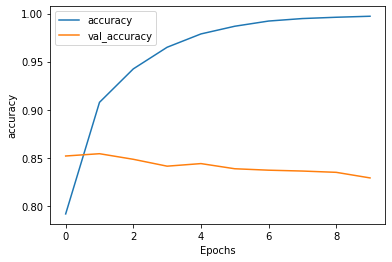

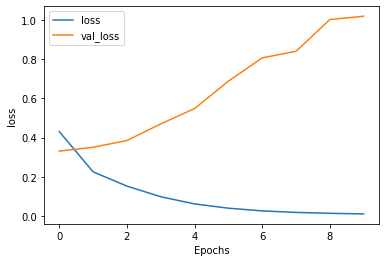

In [ ]:
import matplotlib.pyplot as plt

# # Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

#### Model 2: LSTM Model (GloVe)

In [27]:
# vocab_size = 10000
embedding_dim = 50
num_tokens = vocab_size + 1

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for index in range(2, num_tokens):
    word = index_word[index]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
# Parameters
lstm_dim = 32
dense_dim = 24
dropout_rate = 0.6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_tokens, embedding_dim, input_length=max_length, 
                              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                              trainable=False),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True)),
    # tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Print the model summary
model_lstm.summary()

NUM_EPOCHS = 15

# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 50)            500050    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               21248     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                      

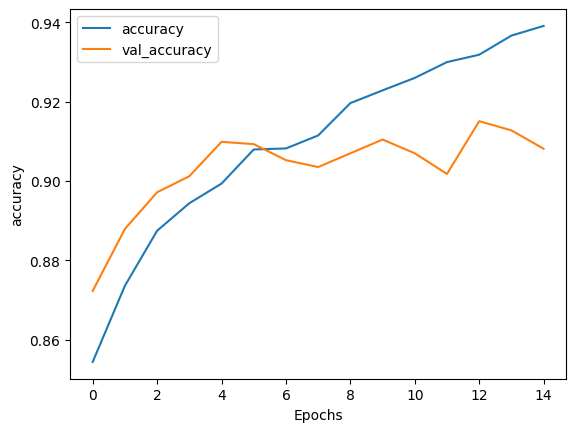

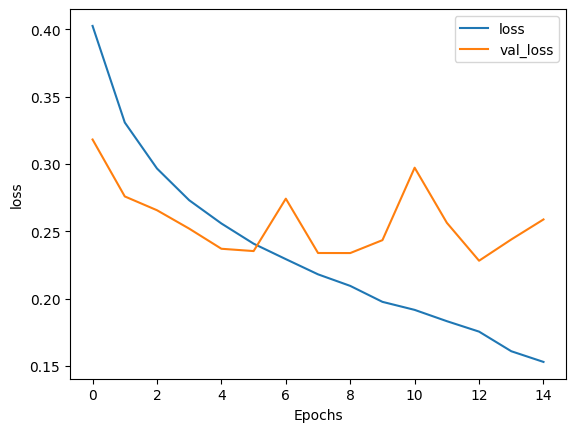

In [29]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

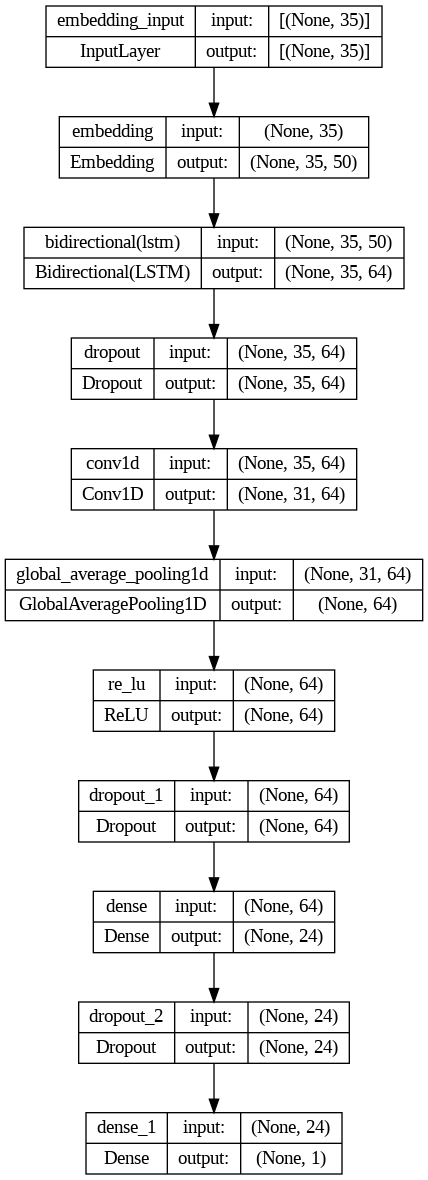

In [30]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='sarcasm_model.png')

In [31]:
save_model_tokenizer(model_lstm, tokenizer, name_tag='sarcasm')

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

NameError: ignored

In [ ]:
# !zip -r /content/tweet_classification_models.zip /content/saved_model
!tar -czvf /content/tweet_classification_models.tar.gz /content/saved_model

from google.colab import files
files.download("/content/tweet_classification_models.tar.gz")

tar: Removing leading `/' from member names
/content/saved_model/
/content/saved_model/sarcasm_model/
/content/saved_model/sarcasm_model/saved_model.pb
/content/saved_model/sarcasm_model/keras_metadata.pb
/content/saved_model/sarcasm_model/fingerprint.pb
/content/saved_model/sarcasm_model/variables/
/content/saved_model/sarcasm_model/variables/variables.index
/content/saved_model/sarcasm_model/variables/variables.data-00000-of-00001
/content/saved_model/sarcasm_model/assets/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!tar -xzvf /content/tweet_classification_models.tar.gz

content/saved_model/
content/saved_model/sarcasm_tokenizer.pickle
content/saved_model/sentiment_model/
content/saved_model/sentiment_model/assets/
content/saved_model/sentiment_model/fingerprint.pb
content/saved_model/sentiment_model/saved_model.pb
content/saved_model/sentiment_model/variables/
content/saved_model/sentiment_model/variables/variables.data-00000-of-00001
content/saved_model/sentiment_model/variables/variables.index
content/saved_model/sentiment_model/keras_metadata.pb
content/saved_model/sentiment_tokenizer.pickle
content/saved_model/sarcasm_model/
content/saved_model/sarcasm_model/assets/
content/saved_model/sarcasm_model/fingerprint.pb
content/saved_model/sarcasm_model/saved_model.pb
content/saved_model/sarcasm_model/variables/
content/saved_model/sarcasm_model/variables/variables.data-00000-of-00001
content/saved_model/sarcasm_model/variables/variables.index
content/saved_model/sarcasm_model/keras_metadata.pb


In [ ]:
test_sequences = tokenizer.texts_to_sequences([['How late can this actually get?']])
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
new_model.predict(test_sequences)

1/1 [==============================] - 2s 2s/step


array([[0.49698642]], dtype=float32)

In [ ]:
1 ^ 0

1

## Combined Model performance 

In [ ]:
# Note: Make sure the paths to the model and Sentiment data are correct below in the 'load_model' function
# and 'filepath' variables

In [53]:
import emoji
# import snscrape.modules.twitter as sntwitter

import os
import sys
import re
import pickle
import json

import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [54]:
class TSAClassifier:
    def __init__(self, model_path, tokenizer_path, max_length=35, print_summary=False):
        self.model = tf.keras.models.load_model(model_path)
        with open(tokenizer_path, 'rb') as handle:
            self.tokenizer = pickle.load(handle)
        if print_summary == True:
            model.summary()
        self.max_length = max_length
    
    def predict(self, input_sentences, round_results=True):
        input_sentences = [re.sub(r'[_:.]', r' ', emoji.demojize(re.sub(r'#(\w+)\b', r'\1', sentence))) for sentence in input_sentences]
        sequences = self.tokenizer.texts_to_sequences(input_sentences)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length)
        if round_results:
                return np.round(self.model.predict(padded_sequences))#.tolist()
        return self.model.predict(padded_sequences)#.tolist()

def load_model():
    model_path = os.path.join(os.getcwd(), 'saved_model', 'sentiment_model')
    tokenizer_path = os.path.join(os.getcwd(), 'saved_model', 'sentiment_tokenizer.pickle')

    sentiment_model = TSAClassifier(model_path, tokenizer_path, max_length=35)

    model_path = os.path.join(os.getcwd(), 'saved_model', 'sarcasm_model')
    tokenizer_path = os.path.join(os.getcwd(), 'saved_model', 'sarcasm_tokenizer.pickle')

    sarcasm_model = TSAClassifier(model_path, tokenizer_path, max_length=35)

    return sentiment_model, sarcasm_model

In [55]:
sentiment_model, sarcasm_model = load_model()

In [ ]:
# Loading Sentiment data
filepath = 'train.csv'
train_sentences, train_labels, validation_sentences, validation_labels = pre_processing(filepath, split_size=0.9, training_data=True)
filepath = 'test.csv'
test_sentences, test_labels = pre_processing(filepath, training_data=False)

In [ ]:
# Checking examples
index = 2
print(validation_sentences[index])
print(validation_sequences[index])
print(validation_labels[index])

how do i teach my girls to love their bodies when i hate mine?
[17, 17, 36, 3, 27, 26, 111, 165, 251, 219, 2157, 405]
0


In [ ]:
# Loading Sarcasm data
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    if item['is_sarcastic'] == 1 and np.random.choice([0, 1], p=[0.8, 0.2]):
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])
    elif item['is_sarcastic'] == 0: 
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])

# print('Dataset size:', len(sentences))

training_size = int(len(sentences)*0.9)

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [49]:
# Use this to check accuracy on validation set of Sentiment data. You can change
# variables to check for appropriate data you need from above cells.
tweet_list = validation_sentences
tweet_labels = validation_labels


sentiment_preds = np.squeeze(sentiment_model.predict(tweet_list, round_results=True))
sarcasm_preds = np.squeeze(sarcasm_model.predict(tweet_list, round_results=True))

if sentiment_preds.shape == ():
    sentiment_preds, sarcasm_preds = [int(sentiment_preds)], [int(sarcasm_preds)]
    # combined_preds = sentiment_preds ^ sarcasm_preds
combined_preds = np.array([int(i)^int(j) for i, j in zip(sentiment_preds, sarcasm_preds)])

print('Sentiment Prediction:', sentiment_preds)
print('Sarcasm Prediction:', sarcasm_preds)
print('Combined Prediction:', combined_preds)

66/66 [==============================] - 0s 3ms/step
Sentiment Prediction: [0. 0. 1. ... 1. 1. 1.]
Sarcasm Prediction: [0. 0. 0. ... 0. 0. 0.]
Combined Prediction: [0 0 1 ... 1 1 1]


In [51]:
# Accuracy
print('Combined model accuracy:', np.sum(tweet_labels == combined_preds) / len(tweet_labels))

Combined model accuracy: 0.7804182509505704
